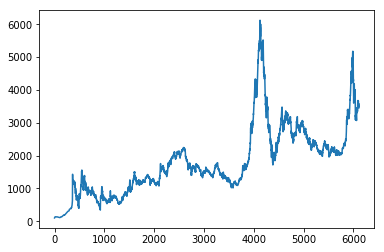

In [12]:
#coding=utf8

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#——————————————————导入数据——————————————————————
f=open('stock_dataset_1.csv')  
df=pd.read_csv(f)     #读入股票数据
data=np.array(df['max_price'])   #获取最高价序列
data=data[::-1]      #反转，使数据按照日期先后顺序排列
#以折线图展示data
plt.figure()
plt.plot(data)
plt.show()
normalize_data=(data-np.mean(data))/np.std(data)  #标准化
normalize_data=normalize_data[:,np.newaxis]       #增加维度


#生成训练集
#设置常量
time_step=20      #时间步
rnn_unit=10       #hidden layer units
batch_size=60     #每一批次训练多少个样例
input_size=1      #输入层维度
output_size=1     #输出层维度
lr=0.0006         #学习率
train_x,train_y=[],[]   #训练集
for i in range(len(normalize_data)-time_step-1):
    x=normalize_data[i:i+time_step]
    y=normalize_data[i+1:i+time_step+1]
    train_x.append(x.tolist())
    train_y.append(y.tolist()) 

In [48]:
print np.array(train_x).shape
print len(train_x)
print len(train_x[0])
print train_x[0]
print tf.reshape(train_x[0:60],[-1,input_size])
w_intest=tf.Variable(tf.random_normal([input_size,rnn_unit]))
print w_intest.shape
b_intest=tf.Variable(tf.constant(0.1,shape=[rnn_unit,]))
print b_intest.shape
print b_intest
input_rnn_test = tf.matmul(tf.reshape(train_x[0:60],[-1,input_size]), w_intest)+b_intest
print tf.reshape(input_rnn_test,[-1,time_step,rnn_unit]).shape

(6090, 20, 1)
6090
20
[[-1.5961875451103236], [-1.5920289935368048], [-1.5875592578319344], [-1.5824482942200362], [-1.577073295587597], [-1.5723395248621856], [-1.5723300950400234], [-1.571226805847049], [-1.570132946476237], [-1.5689730783502895], [-1.567747201469207], [-1.5665213245881242], [-1.5659366756140696], [-1.5653520266400147], [-1.5647296583773114], [-1.5641355795810943], [-1.563532070962715], [-1.562985141277309], [-1.5634094832746068], [-1.5634094832746068]]
Tensor("Reshape_19:0", shape=(1200, 1), dtype=float32)
(1, 10)
(10,)
<tf.Variable 'Variable_14:0' shape=(10,) dtype=float32_ref>
(60, 20, 10)


In [60]:
graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):
    #——————————————————定义神经网络变量——————————————————
    X=tf.placeholder(tf.float32, [None,time_step,input_size])    #每批次输入网络的tensor
    Y=tf.placeholder(tf.float32, [None,time_step,output_size])   #每批次tensor对应的标签
    #输入层、输出层权重、偏置
    weights={
             'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
             'out':tf.Variable(tf.random_normal([rnn_unit,1]))
             }
    biases={
            'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
            'out':tf.Variable(tf.constant(0.1,shape=[1,]))
            }

    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit, reuse = tf.AUTO_REUSE)

    #——————————————————定义神经网络变量——————————————————
    def lstm(X, weights, biases, batch):      #参数：输入网络批次数目
        w_in=weights['in']
        b_in=biases['in']
        input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
        input_rnn=tf.matmul(input,w_in)+b_in
        input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
        init_state=cell.zero_state(batch,dtype=tf.float32)
        #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
        output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state, dtype=tf.float32)  
        output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
        w_out=weights['out']
        b_out=biases['out']
        pred=tf.matmul(output,w_out)+b_out
        return pred,final_states
    
    global batch_size
    pred,_=lstm(X, weights, biases, batch_size)
    preddd,_xxxx=lstm(X, weights, biases, 1)
    #损失函数
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    #saver=tf.train.Saver(tf.global_variables())

In [72]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #重复训练10000次
    for i in range(100):
        step=0
        start=0
        end=start+batch_size
        while(end<len(train_x)):
            _,loss_,predictions=sess.run([train_op,loss,pred],feed_dict={X:train_x[start:end],Y:train_y[start:end]})
            start+=batch_size
            end=start+batch_size
            #每10步保存一次参数
            if i%100==0 and step==100:
                print(i,step,loss_)
                #print("save model：",saver.save(sess,'./stock/stock.model'))
            step+=1
    
    prev_seq=train_x[0]
    predict=[]
    for i in range(100):
        next_seq=sess.run(preddd,feed_dict={X:[prev_seq]})
        predict.append(next_seq[-1])
        #每次得到最后一个时间步的预测结果，与之前的数据加在一起，形成新的测试样本
        prev_seq=np.vstack((prev_seq[1:],next_seq[-1]))
    #以折线图表示结果
   

(0, 100, 0.43740225)


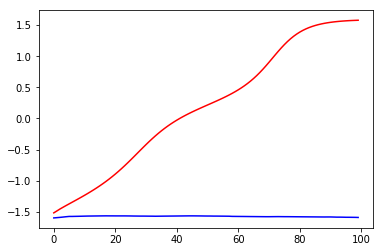

In [74]:
 plt.figure()
plt.plot(list(range(len(predict))), normalize_data[0:len(predict)], color='b')
plt.plot(list(range(len(predict))), predict, color='r')
plt.show()

In [50]:
print predictions.shape
tf.reshape(predictions,[-1])

(1200, 1)


<tf.Tensor 'Reshape_22:0' shape=(1200,) dtype=float32>

In [52]:
def prediction():
    pred,_=lstm(1)      #预测时只输入[1,time_step,input_size]的测试数据
    #saver=tf.train.Saver(tf.global_variables())
with tf.Session(graph=graph) as sess:
    #参数恢复
    #module_file = tf.train.latest_checkpoint(base_path+'module2/')
    #saver.restore(sess, module_file) 

    #取训练集最后一行为测试样本。shape=[1,time_step,input_size]
    prev_seq=train_x[-1]
    predict=[]
    #得到之后100个预测结果
    for i in range(100):
        next_seq=sess.run(pred,feed_dict={X:[prev_seq]})
        predict.append(next_seq[-1])
        #每次得到最后一个时间步的预测结果，与之前的数据加在一起，形成新的测试样本
        prev_seq=np.vstack((prev_seq[1:],next_seq[-1]))
    #以折线图表示结果
    plt.figure()
    plt.plot(list(range(len(normalize_data))), normalize_data, color='b')
    plt.plot(list(range(len(normalize_data), len(normalize_data) + len(predict))), predict, color='r')
    plt.show()


FailedPreconditionError: Attempting to use uninitialized value Variable_3
	 [[Node: Variable_3/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_3"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_3)]]

Caused by op u'Variable_3/read', defined at:
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-884a7a1875a9>", line 13, in <module>
    'out':tf.Variable(tf.constant(0.1,shape=[1,]))
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable_3
	 [[Node: Variable_3/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_3"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_3)]]
